## **Clasificacion de Fashion MNIST con Pytorch usando una CNN**

Usaremos el aprendizaje profundo en el conjunto de datos FashionMNIST usando Pytorch. Construiremos una red neuronal convolucional para predecir las clases de conjunto de datos.

# Librerias Usadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


# Cargar Datos

Hay 2 formas de cargar el conjunto de datos Fashion MNIST

1. Cargar el csv y luego heredar la clase Pytorch Dataset.
2. Utilice el módulo de Pytorch torchvision.datasets. Tiene muchos conjuntos de datos populares como MNIST, FashionMNIST, CIFAR10 e.t.c.

In [3]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))  

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

Tenemos 10 tipos de ropa en el conjunto de datos FashionMNIST.
Haciendo un método que devuelva el nombre de la clase para el número de etiqueta. Por ejemplo, si la etiqueta es 5, devolvemos Sandal.

In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Jugando con datos y mostrando algunas imágenes usando el método matplotlib imshow ().

In [6]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [7]:
len(train_set)

60000

In [8]:
len(test_set)

10000

9


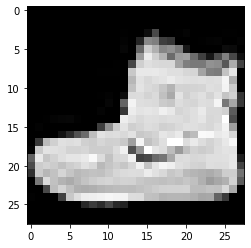

In [9]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [10]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

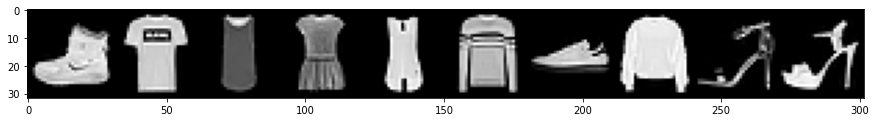

In [11]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

# Construccion de la CNN

* Se hizo una clase de modelo (FashionCNN)

  * Heredara la clase nn.Module que es una superclase para todas las redes neuronales en Pytorch.

* La red neuronal tiene las siguientes capas:

* Dos capas secuenciales, cada una consta de las siguientes capas:

  * Capa de convolución que tiene un kernel  de tamaño 3 * 3, padding = 1 (zero_padding) en la primera capa y padding = 0 en la segunda. Zancada de 1 en ambas capas.

  * Capa de normalización por batches.

  * Función de activación: ReLU.

  * Capa de Max Pooling con tamaño de kernel  de 2 * 2 y paso de 2.

    * Aplanar la salida para una capa densa (también conocida como capa completamente conectada).

    * 3 Capa completamente conectada con diferentes características de entrada / salida.

    * 1 Capa de deserción que tiene probabilidad de clase p = 0.25.

  * Toda la funcionalidad se da en el método hacia adelante que define el pase hacia adelante de la CNN.

  * La imagen de entrada estara cambiando de la siguiente manera:

    * Primera capa de convulación: entrada: 28 * 28 * 3, salida: 28 * 28 * 32

    * Primera capa de Max Pooling: entrada: 28 * 28 * 32, salida: 14 * 14 * 32

    * Segunda capa de conv: entrada: 14 * 14 * 32, salida: 12 * 12 * 64

    * Segunda capa de Max Pooling: 12 * 12 * 64, salida: 6 * 6 * 64

* La capa final completamente conectada tiene 10 caracteristicas de salida para 10 tipos de ropa.

Vamos a implementar la red ...



In [12]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

Haciendo el modelo de nuestra clase CNN
* Creando un objeto (model en el código)
* Transferirlo a la GPU si está disponible.
* Definición de una función de pérdida. estamos usando CrossEntropyLoss() aquí.
* Usamos el algoritmo de Adam con fines de optimización.

In [27]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


# Entrenado de la red y tests en el conjunto de datos de prueba

TEST PARA learning_rate DE 0.001
FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
TRAIN PARA 2 EPOCHES
Iteration: 500, Loss: 0.4239194095134735, Accuracy: 87.48999786376953%
Iteration: 1000, Loss: 0.35503819584846497, Accuracy: 88.27999877

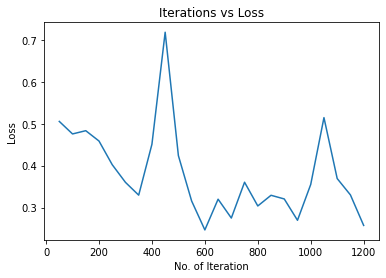

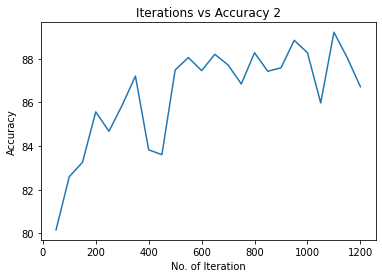

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 76.30%
Accuracy of Trouser: 98.90%
Accuracy of Pullover: 58.50%
Accuracy of Dress: 89.80%
Accuracy of Coat: 94.60%
Accuracy of Sandal: 90.90%
Accuracy of Shirt: 66.70%
Accuracy of Sneaker: 97.40%
Accuracy of Bag: 98.80%
Accuracy of Ankle Boot: 96.20%
###############################################################################
TRAIN PARA 5 EPOCHES
Iteration: 500, Loss: 0.31846386194229126, Accuracy: 90.04999542236328%
Iteration: 1000, Loss: 0.3169816732406616, Accuracy: 89.65999603271484%
Iteration: 1200, Loss: 0.2211211770772934, Accuracy: 88.91999816894531%
Iteration: 1500, Loss: 0.20440471172332764, Accuracy: 89.3499984741211%
Iteration: 2000, Loss: 0.2274874895811081, Accuracy: 89.27999877929688%
Iteration: 2400, Loss: 0.191910520195961, Accuracy: 89.8499984741211%
Iteration: 2500, Loss: 0.11934958398342133, Accuracy: 89.95999908447266%
Iteration: 3000, Loss: 0.1326245218515396, Accurac

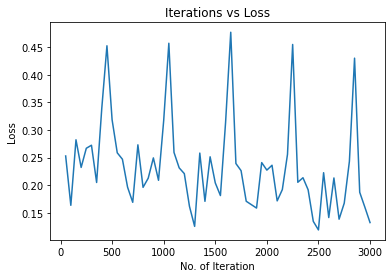

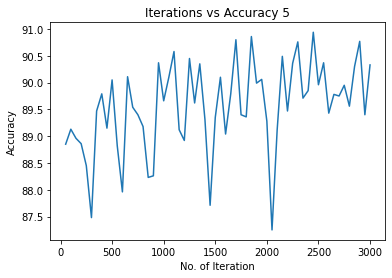

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 90.50%
Accuracy of Trouser: 97.80%
Accuracy of Pullover: 82.20%
Accuracy of Dress: 89.70%
Accuracy of Coat: 86.90%
Accuracy of Sandal: 95.10%
Accuracy of Shirt: 69.80%
Accuracy of Sneaker: 98.70%
Accuracy of Bag: 99.10%
Accuracy of Ankle Boot: 94.60%
###############################################################################
TRAIN PARA 10 EPOCHES
Iteration: 500, Loss: 0.20528097450733185, Accuracy: 90.55999755859375%
Iteration: 1000, Loss: 0.21110109984874725, Accuracy: 89.97000122070312%
Iteration: 1200, Loss: 0.1556015908718109, Accuracy: 90.43999481201172%
Iteration: 1500, Loss: 0.09750661253929138, Accuracy: 88.87999725341797%
Iteration: 2000, Loss: 0.12757863104343414, Accuracy: 89.3699951171875%
Iteration: 2400, Loss: 0.0824936106801033, Accuracy: 90.05999755859375%
Iteration: 2500, Loss: 0.07876959443092346, Accuracy: 90.5%
Iteration: 3000, Loss: 0.07177655398845673, Accuracy: 90.2

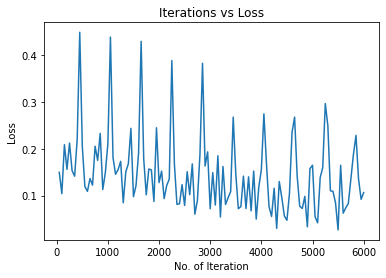

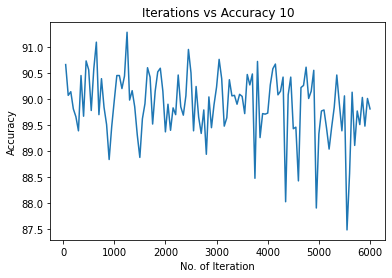

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 92.50%
Accuracy of Trouser: 97.00%
Accuracy of Pullover: 81.40%
Accuracy of Dress: 91.70%
Accuracy of Coat: 93.10%
Accuracy of Sandal: 96.70%
Accuracy of Shirt: 53.90%
Accuracy of Sneaker: 97.30%
Accuracy of Bag: 97.10%
Accuracy of Ankle Boot: 96.20%
###############################################################################
TEST PARA learning_rate DE 0.002
FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, paddin

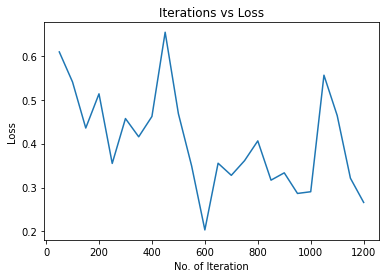

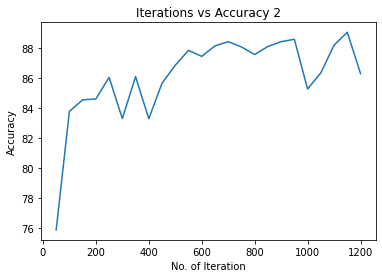

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 81.90%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 55.00%
Accuracy of Dress: 93.30%
Accuracy of Coat: 94.90%
Accuracy of Sandal: 90.40%
Accuracy of Shirt: 62.20%
Accuracy of Sneaker: 99.10%
Accuracy of Bag: 97.40%
Accuracy of Ankle Boot: 92.60%
###############################################################################
TRAIN PARA 5 EPOCHES
Iteration: 500, Loss: 0.3221769630908966, Accuracy: 90.16999816894531%
Iteration: 1000, Loss: 0.2753434479236603, Accuracy: 90.61000061035156%
Iteration: 1200, Loss: 0.15789459645748138, Accuracy: 89.98999786376953%
Iteration: 1500, Loss: 0.22830478847026825, Accuracy: 87.29999542236328%
Iteration: 2000, Loss: 0.18574757874011993, Accuracy: 90.0199966430664%
Iteration: 2400, Loss: 0.15163852274417877, Accuracy: 90.3699951171875%
Iteration: 2500, Loss: 0.1024378314614296, Accuracy: 90.32999420166016%
Iteration: 3000, Loss: 0.15173642337322235, Accu

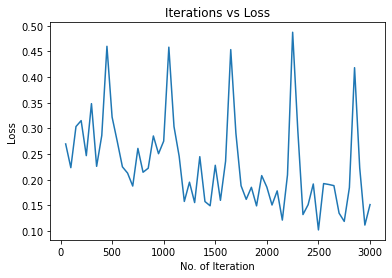

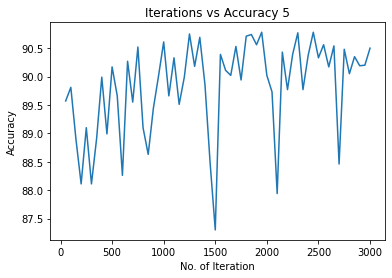

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 89.30%
Accuracy of Trouser: 98.80%
Accuracy of Pullover: 84.00%
Accuracy of Dress: 88.20%
Accuracy of Coat: 85.20%
Accuracy of Sandal: 96.70%
Accuracy of Shirt: 70.70%
Accuracy of Sneaker: 97.20%
Accuracy of Bag: 98.90%
Accuracy of Ankle Boot: 96.80%
###############################################################################
TRAIN PARA 10 EPOCHES
Iteration: 500, Loss: 0.2126186192035675, Accuracy: 90.5999984741211%
Iteration: 1000, Loss: 0.12610089778900146, Accuracy: 89.4000015258789%
Iteration: 1200, Loss: 0.18001796305179596, Accuracy: 90.3499984741211%
Iteration: 1500, Loss: 0.13605646789073944, Accuracy: 88.86000061035156%
Iteration: 2000, Loss: 0.18456658720970154, Accuracy: 90.29999542236328%
Iteration: 2400, Loss: 0.1625075340270996, Accuracy: 89.70999908447266%
Iteration: 2500, Loss: 0.05778888240456581, Accuracy: 89.44999694824219%
Iteration: 3000, Loss: 0.09580124169588089, Acc

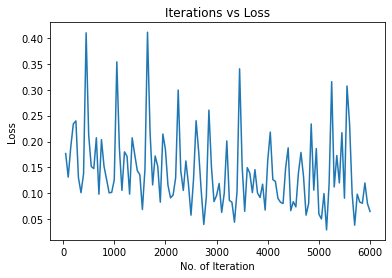

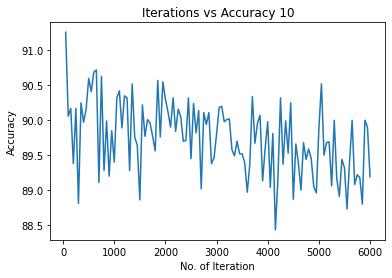

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 95.00%
Accuracy of Trouser: 97.00%
Accuracy of Pullover: 82.30%
Accuracy of Dress: 82.60%
Accuracy of Coat: 88.90%
Accuracy of Sandal: 95.70%
Accuracy of Shirt: 57.80%
Accuracy of Sneaker: 97.80%
Accuracy of Bag: 97.10%
Accuracy of Ankle Boot: 96.00%
###############################################################################
TEST PARA learning_rate DE 0.003
FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, paddin

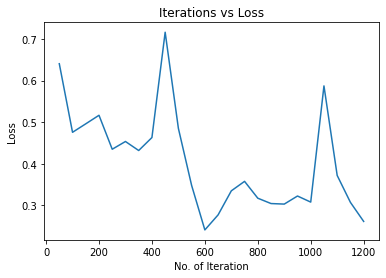

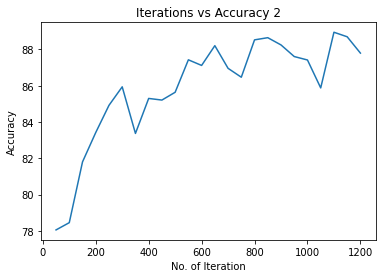

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 79.50%
Accuracy of Trouser: 97.80%
Accuracy of Pullover: 64.00%
Accuracy of Dress: 93.00%
Accuracy of Coat: 91.10%
Accuracy of Sandal: 92.80%
Accuracy of Shirt: 69.80%
Accuracy of Sneaker: 99.10%
Accuracy of Bag: 98.20%
Accuracy of Ankle Boot: 92.60%
###############################################################################
TRAIN PARA 5 EPOCHES
Iteration: 500, Loss: 0.2873700261116028, Accuracy: 90.04999542236328%
Iteration: 1000, Loss: 0.31445223093032837, Accuracy: 89.5%
Iteration: 1200, Loss: 0.14984899759292603, Accuracy: 89.98999786376953%
Iteration: 1500, Loss: 0.19991348683834076, Accuracy: 89.47000122070312%
Iteration: 2000, Loss: 0.2341814488172531, Accuracy: 89.20999908447266%
Iteration: 2400, Loss: 0.17361706495285034, Accuracy: 89.12999725341797%
Iteration: 2500, Loss: 0.1258465051651001, Accuracy: 89.5199966430664%
Iteration: 3000, Loss: 0.12820486724376678, Accuracy: 90.040

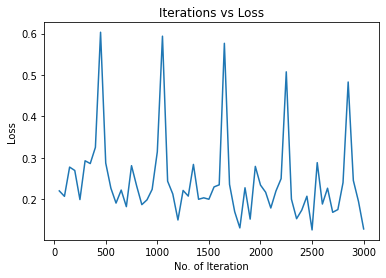

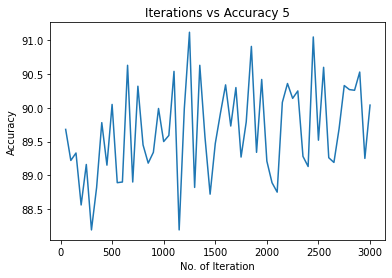

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 85.70%
Accuracy of Trouser: 98.10%
Accuracy of Pullover: 70.70%
Accuracy of Dress: 90.90%
Accuracy of Coat: 92.60%
Accuracy of Sandal: 96.80%
Accuracy of Shirt: 72.30%
Accuracy of Sneaker: 96.10%
Accuracy of Bag: 98.80%
Accuracy of Ankle Boot: 97.20%
###############################################################################
TRAIN PARA 10 EPOCHES
Iteration: 500, Loss: 0.18814954161643982, Accuracy: 90.88999938964844%
Iteration: 1000, Loss: 0.19335569441318512, Accuracy: 88.82999420166016%
Iteration: 1200, Loss: 0.12216899544000626, Accuracy: 89.6199951171875%
Iteration: 1500, Loss: 0.12107736617326736, Accuracy: 89.5199966430664%
Iteration: 2000, Loss: 0.17521558701992035, Accuracy: 89.07999420166016%
Iteration: 2400, Loss: 0.18975946307182312, Accuracy: 89.97999572753906%
Iteration: 2500, Loss: 0.0817536860704422, Accuracy: 90.04999542236328%
Iteration: 3000, Loss: 0.06156207248568535, A

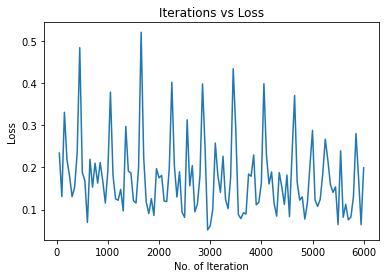

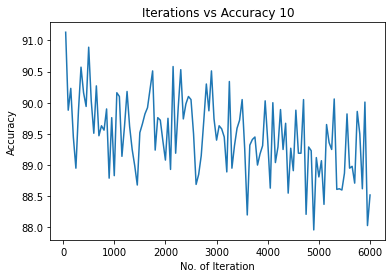

Buscando la precisión en cada clase de conjunto de datos FashionMNIST
Accuracy of T-shirt/Top: 95.50%
Accuracy of Trouser: 96.80%
Accuracy of Pullover: 77.60%
Accuracy of Dress: 90.10%
Accuracy of Coat: 85.90%
Accuracy of Sandal: 95.10%
Accuracy of Shirt: 52.40%
Accuracy of Sneaker: 96.50%
Accuracy of Bag: 97.40%
Accuracy of Ankle Boot: 97.20%
###############################################################################


In [35]:
learningRatesVals = [0.001, 0.002, 0.003]
for learning_rate in learningRatesVals:
  print("TEST PARA learning_rate DE {}".format(learning_rate))
  model = FashionCNN()
  model.to(device)

  error = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  print(model)

  epochesranges = [2, 5, 10]

  for num_epochs in epochesranges: 
    print("TRAIN PARA {} EPOCHES".format(num_epochs))
    count = 0
    # Listas para visualización de pérdidas y precisión
    loss_list = []
    iteration_list = []
    accuracy_list = []

    # Listas para conocer la precisión de clase
    predictions_list = []
    labels_list = []

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Transferencia de imágenes y etiquetas a la GPU si está disponible
            images, labels = images.to(device), labels.to(device)
        
            train = Variable(images.view(100, 1, 28, 28))
            labels = Variable(labels)
            
            # paso del Forward 
            outputs = model(train)
            loss = error(outputs, labels)
            
            # Inicializa un gradiente como 0 para que no haya mezcla de gradiente entre los batches
            optimizer.zero_grad()
            
            #Porpagacion del error backward
            loss.backward()
            
            # Optimizando los parámetros
            optimizer.step()
        
            count += 1
        
            # Probando el modelo
            #print(count)
            if (count % 50 == 0):
                total = 0
                correct = 0
            
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                
                    test = Variable(images.view(100, 1, 28, 28))
                
                    outputs = model(test)
                
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()
                
                    total += len(labels)
                
                accuracy = correct * 100 / total
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            
            if not (count % 500):
                print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

            if not (count % 1200):
                print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

    print("Visualización de la pérdida y la precisión con iteraciones")
    plt.plot(iteration_list, loss_list)
    plt.xlabel("No. of Iteration")
    plt.ylabel("Loss")
    plt.title("Iterations vs Loss".format(num_epochs))
    plt.show()

    plt.plot(iteration_list, accuracy_list)
    plt.xlabel("No. of Iteration")
    plt.ylabel("Accuracy")
    plt.title("Iterations vs Accuracy {}".format(num_epochs))
    plt.show()

    print("Buscando la precisión en cada clase de conjunto de datos FashionMNIST")
    class_correct = [0. for _ in range(10)]
    total_correct = [0. for _ in range(10)]

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            test = Variable(images)
            outputs = model(test)
            predicted = torch.max(outputs, 1)[1]
            c = (predicted == labels).squeeze()
            
            for i in range(100):
                label = labels[i]
                class_correct[label] += c[i].item()
                total_correct[label] += 1
            
    for i in range(10):
        print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

    print("###############################################################################")

Visualización de la pérdida y la precisión con iteraciones

Buscando la precisión en cada clase de conjunto de datos FashionMNIST